## 1 Beginning



### 1.1 Problem

We are dealing with a traditional supervised document classification challenge, where a substantial number of text files have already been sorted into their corresponding categories.

#### Dataset

- Data consists of 2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005.
- Natural Classes: 5 (business, entertainment, politics, sport, tech)

> All rights, including copyright, in the content of the original articles are owned by the BBC.
D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.

### 1.2 Solution

Construct a Neural Network for the purpose of categorizing documents according to their textual content. 

The Document Classification task is segmented into two key phases:

1. Step 1 - Preprocessing:

    - Refine and condense the textual content in files by eliminating redundant spaces and newlines.
    - Utilize [spaCy][1] for language processing.

2. Step 2 - Modeling:

    - Use a [neural network architecture][2] for this specific solution.
    - Visualize and graph performance metrics.

[1]: https://spacy.io/api/ 
[2]: https://www.kaggle.com/code/dheemanthbhat/bbc-text-classification-part-2-modeling

### 1.3 Project structure

Project: BBC Full Text Document Classification

- **code:**
  - BBC Document Classification Part 1 - Preprocessing.ipynb
  - BBC Document Classification Part 2 - Modeling.ipynb

- **input:**
  - **bbc-full-text-document-classification:**
    - README.TXT
    - **business:**
      - 001.txt, 002.txt, ..., (Total 510 files)
    - **entertainment:**
      - 001.txt, 002.txt, ..., (Total 386 files)
    - **politics:**
      - 001.txt, 002.txt, ..., (Total 417 files)
    - **sport:**
      - 001.txt, 002.txt, ..., (Total 511 files)
    - **tech:**
      - 001.txt, 002.txt, ..., (Total 401 files)

  - **bbc-text-preprocessed:**
    - docs_stage_1_metadata.csv
    - docs_stage_2_parsed_text.csv
    - docs_stage_3_preprocessed.csv

  - **glove-global-vectors-for-word-representation:**
    - glove.6B.100d.txt

- **logs:**
  - **train**
  - **validation**

- **models:**
  - epoch-01_accuracy-0.2520.hdf5
  - ...
  - epoch-13_accuracy-0.9718.hdf5


<!-- 
BBC Full Text Document Classification
    ├───code
    │       BBC Document Classification Part 1 - Preprocessing.ipynb
    │       BBC Document Classification Part 2 - Modeling.ipynb
    │
    ├───input
    │   ├───bbc-full-text-document-classification
    │   │   └───bbc
    │   │       │   README.TXT
    │   │       ├───business
    │   │       │       001.txt
    │   │       │       002.txt
    │   │       │       ...                          (Total 510 files)
    │   │       ├───entertainment
    │   │       │       001.txt
    │   │       │       002.txt
    │   │       │       ...                          (Total 386 files)
    │   │       ├───politics
    │   │       │       001.txt
    │   │       │       002.txt
    │   │       │       ...                          (Total 417 files)
    │   │       ├───sport
    │   │       │       001.txt
    │   │       │       002.txt
    │   │       │       ...                          (Total 511 files)
    │   │       └───tech
    │   │               001.txt
    │   │               002.txt
    │   │               ...                          (Total 401 files)
    │   │
    │   ├───bbc-text-preprocessed
    │   │       docs_stage_1_metadata.csv
    │   │       docs_stage_2_parsed_text.csv
    │   │       docs_stage_3_preprocessed.csv
    │   │
    │   └───glove-global-vectors-for-word-representation
    │           glove.6B.100d.txt
    │
    ├───logs
    │   ├───train
    │   └───validation
    │
    └───models
            epoch-01_accuracy-0.2520.hdf5
            ...
            epoch-13_accuracy-0.9718.hdf5
 -->

## 2 Setup

### 2.1 Import and configure libraries

In [5]:
# Data manipulation libraries
import numpy as np
import pandas as pd
import spacy

# Data visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# General Imports
import os
import re
from tqdm import tqdm
from colorama import Fore, Style

# Library versions
print("Numpy version:", np.__version__)
print("Spacy version:", spacy.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)

# Configure Numpy
# specify that the maximum width of printed lines should be 130 characters
# after 130 characters it will continue in the next line
np.set_printoptions(linewidth=130)

# Configure Seaborn
sns.set_style("whitegrid") # set white background with grid
sns.set_palette("deep") # set color palette
sns.set_context("paper", font_scale=1.25) # set font to scale 1.25 , greater than default

Numpy version: 1.24.3
Spacy version: 3.7.2
Pandas version: 2.0.3
Matplotlib version: 3.7.4
Seaborn version: 0.12.2


### 2.2 Constants and helper functions

#### Constants

In [6]:
DOCS_DIR = "/kaggle/input/bbc-full-text-document-classification/bbc"
METADATA_CSV = "/kaggle/working/docs_stage_1_metadata.csv"


#### Helper functions

In [8]:
def get_duplicate_doc_ids(df):
    """
    Retrieve a list of document ids that appear more than once in the dataset.
    """
    duplicate_doc_ids = [doc_id for doc_id, count in df["DocId"].value_counts().items() if count > 1]
    return duplicate_doc_ids


#### Plotting functions

In [49]:
def plot_percentile_range(lower_limit, upper_limit, column_name, dataframe, y_label):
    """
    Plot the values of a column within a specified percentile range.

    Parameters:
    - lower_limit: float, lower percentile limit
    - upper_limit: float, upper percentile limit
    - column_name: str, the name of the column in the DataFrame
    - dataframe: DataFrame, the input DataFrame
    - y_label: str, label for the y-axis
    """
    plt.figure(figsize=(4, 3))

    # Corrected percentiles to be in the range [0, 1]
    percentiles = np.arange(lower_limit / 100, upper_limit / 100, 0.01)
    values = dataframe[column_name].quantile(q=percentiles)

    sns.lineplot(x=percentiles * 100, y=values)  # Multiply by 100 for proper x-axis labeling
    plt.title(f"{y_label} between {lower_limit}% and {round(upper_limit - 0.01, 2)}% percentile")
    plt.xlabel("Percentile")
    plt.ylabel(y_label)

    plt.show()

# # Example usage
# plot_percentile_range(10, 90, "FileSize", meta_df, "File size in Bytes")


### 2.3 Metadata

Extract and save metadata from document files. Meta data like:

1. **Document type:** Class-label taken from folder name containing documents.
2. **Document Id:** Generated using first character from document type and file name. Example: *B_101*.
3. **File size:** File size in bytes.
4. **File path:** Relative file path.

In [9]:
# This version uses list comprehensions for more concise list creation

if os.path.exists(METADATA_CSV): # Checking for Existing Metadata File: This part checks if a CSV file named METADATA_CSV (presumably a constant containing the file path) exists.
    print("Loading metadata from:", METADATA_CSV)
    meta_df = pd.read_csv(METADATA_CSV)  # If it does, the metadata is loaded into a Pandas DataFrame (meta_df) using pd.read_csv().
else: 
    meta_data = [ #If the metadata file doesn't exist, it creates a list called meta_data using a list comprehension.
        [dir_name.capitalize(), 
         f"{dir_name[0].upper()}_{os.path.splitext(file_name)[0]}", 
         os.path.getsize(os.path.join(DOCS_DIR, dir_name, file_name)), 
         os.path.join(DOCS_DIR, dir_name, file_name)]
        for dir_name in os.listdir(DOCS_DIR) if os.path.isdir(os.path.join(DOCS_DIR, dir_name))
        for file_name in os.listdir(os.path.join(DOCS_DIR, dir_name))
    ]
# The list comprehension iterates over directories and files in the specified DOCS_DIR. It constructs a list for each file with information such as DocType, DocId, FileSize, and FilePath.
    col_names = ["DocType", "DocId", "FileSize", "FilePath"]
    meta_df = pd.DataFrame(meta_data, columns=col_names)
    meta_df.to_csv(METADATA_CSV, index=False, na_rep="") # if there are any missing values in the DataFrame, they will be represented as empty strings in the CSV file.
#     When set to False, the CSV file won't have an additional column for the index.
    print("Metadata saved to:", METADATA_CSV)
# After collecting metadata, it creates a Pandas DataFrame (meta_df) from meta_data and saves it to the CSV file using to_csv().
meta_df["DocType"] = meta_df["DocType"].astype("category")
# Converts the "DocType" column in the DataFrame to a categorical data type.

meta_df.sample(3)


Metadata saved to: /kaggle/working/docs_stage_1_metadata.csv


,DocType,DocId,FileSize,FilePath
1827,Business,B_299,2935,/kaggle/input/bbc-full-text-document-classific...
708,Sport,S_167,771,/kaggle/input/bbc-full-text-document-classific...
1958,Business,B_132,1285,/kaggle/input/bbc-full-text-document-classific...


## 3 EDA (Document Metadata)

In [10]:
rows, cols = meta_df.shape
print(f"Dataset contains {rows} rows and {cols} columns.\n")
      
meta_df.info()

# when you see "object" as the data type in a Pandas DataFrame column, it typically implies that the column contains non-numeric data, such as strings or a mix of different types. 
# In this specific case, "FilePath" likely contains string values representing file paths.

Dataset contains 2225 rows and 4 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   DocType   2225 non-null   category
 1   DocId     2225 non-null   object  
 2   FileSize  2225 non-null   int64   
 3   FilePath  2225 non-null   object  
dtypes: category(1), int64(1), object(2)
memory usage: 54.7+ KB


#### Remarks :

The dataset contains complete information, with every column having values specified for each corresponding entry, ensuring there are **no instances of missing data** across the entire dataset.

### 3.1 Duplicates Check

#### Verify if there are any instances of duplicate 'DocIds' within each category in the dataset

In [15]:
dup_doc_ids = get_duplicate_doc_ids(meta_df)
print(len(dup_doc_ids), "`DocIds` appear more than once in the dataset.")

0 `DocIds` appear more than once in the dataset.


### 3.2 Class-label: `DocType`

In [13]:
import pandas as pd

# Calculate class counts
cls_count = meta_df["DocType"].value_counts()
# print(cls_count)
# Create a DataFrame from the value counts
cls_count_df = pd.DataFrame({"Class label": cls_count.index, "Count": cls_count.values})

# Add a column for serial numbers
cls_count_df["Serial No"] = cls_count_df.index + 1

# Display the DataFrame
print(cls_count_df)


     Class label  Count  Serial No
0          Sport    511          1
1       Business    510          2
2       Politics    417          3
3           Tech    401          4
4  Entertainment    386          5


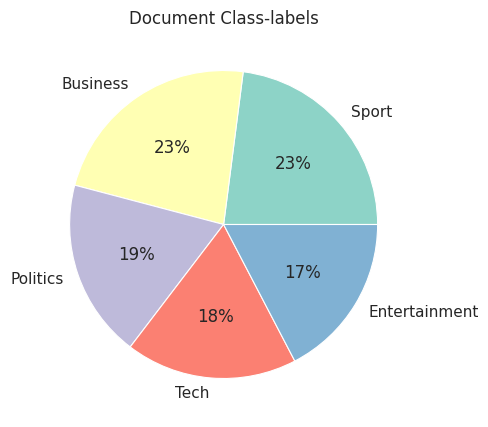

In [23]:
import matplotlib.pyplot as plt

# Calculate class counts
cls_count = meta_df["DocType"].value_counts()

# Create a pie chart with custom colors
colors = plt.cm.Set3.colors
plt.figure(figsize=(5, 5))
plt.pie(x=cls_count, labels=cls_count.index, autopct="%1.0f%%", colors=colors)

# Add a title
plt.title("Document Class-labels")

# Display the pie chart
plt.show()


#### Remarks

The dataset displays a uniform distribution among its classes, showing minimal discrepancies and a well-maintained balance across categories.

### 3.2 Class-label added, encoded DocType: `DocCat`

In [35]:
# Encode class labels
encoded_labels, unique_labels = pd.factorize(meta_df["DocType"])

# Create a mapping from encoded values to original class labels
class_label_mapping = dict(enumerate(unique_labels.categories))

# Display the encoded class labels and their mapping
print("Encoded class-labels:\n", class_label_mapping)

# Add a new column "DocCat" with the encoded values to the DataFrame
meta_df["DocCat"] = encoded_labels

# Display the count of each encoded value in the "DocCat" column
encoded_value_counts = meta_df["DocCat"].value_counts().sort_index()
print("Encoded value counts:\n", encoded_value_counts)


Encoded class-labels:
 {0: 'Business', 1: 'Entertainment', 2: 'Politics', 3: 'Sport', 4: 'Tech'}
Encoded value counts:
 DocCat
0    417
1    511
2    401
3    386
4    510
Name: count, dtype: int64


### 3.3 Class-label: `Filesize`

Text(0, 0.5, 'Document Type')

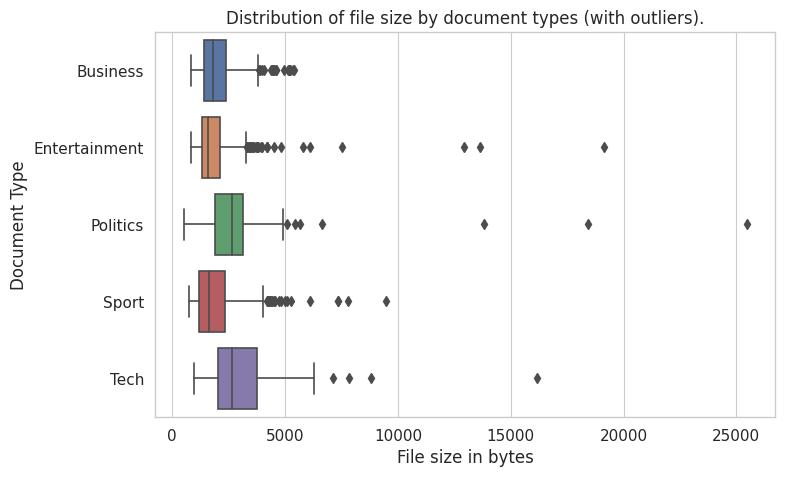

In [43]:
plt.figure(figsize=(8,5))
sns.boxplot(data=meta_df, x="FileSize", y="DocType")
plt.title("Distribution of file size by document types (with outliers).")
plt.xlabel("File size in bytes")
plt.ylabel("Document Type")

#### Remarks

The feature "FileSize" exhibits a significant skewness in its distribution and appears to contain a substantial number of data points that deviate significantly from the overall pattern, commonly referred to as outliers.

#### Identify outliers in the dataset using the Elbow method

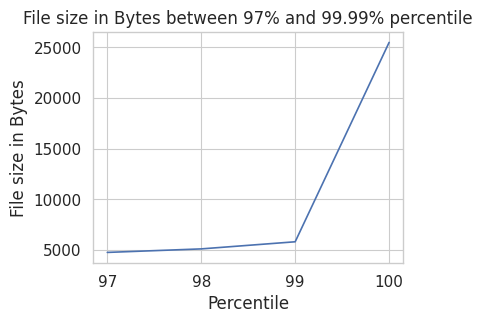

In [48]:
plot_percentile_range(97, 100, "FileSize", meta_df, "File size in Bytes")